# Questions to answer
- [Q1]: Are there distributional differences between categories?
  - I noticed that raw data is skewed towards finance, sports, and travel. What is the distribution of the synthesized dataset?
- [Q2]: Are there differences between, say, tools data vs. finance in terms of lexical variations, API/question diversity, length
- [Q3]: What is the distribution of questions of naturally existing data vs. synthesized data?
  - lexical variations, question diversity, “difficulty” (how to measure?)
- [Q4]: How to improve query diversity? How to move beyond queries LLM can generate?
  - e.g. local search around generated API? can also exhaustive search but probably expensive
  - idea is to verify queries that LLMs are not able to generate
- [Q5]: How to go to multi-turn from single-turn? For instance compositional API calling dataset?

In [1]:
from datasets import load_dataset
apigen_datasets = load_dataset("Salesforce/xlam-function-calling-60k")['train']
print(f"Features are {apigen_datasets.features}")

/scratch/ssd004/scratch/arthur/micromamba/envs/apigen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Features are {'query': Value(dtype='string', id=None), 'id': Value(dtype='int64', id=None), 'answers': Value(dtype='string', id=None), 'tools': Value(dtype='string', id=None)}


In [2]:
# let's classify the data into different categories
# we can only classify the data into all 4 categories: 1) simple, 2) multiple, 3) parallel, 4) multiple parallel
# although the data is not labeled
# 1) it's simple if it contains only one function call in the answer, and the tool list only contains one tool
# 2) it's multiple if it contains only one function call in the answer, and the tool list contains multiple tools
# 3) it's parallel if it contains multiple function calls in the answer, and the tool list only contains one tool
# 4) it's parallel multiple if it contains multiple function calls in the answer, and the tool list contains multiple tools
import json


def classify_apigen_data(datasets, duplicated_tool_names_idxes: list[int]) -> dict:
    result = {'simple': [], 'multiple': [], 'parallel': [], 'parallel_multiple': []}
    for item in datasets:
        answers = json.loads(item['answers'])
        answer_names = [answer['name'] for answer in answers]

        tools = json.loads(item['tools'])
        tool_names = [tool['name'] for tool in tools]
        tool_parameters = [tool['parameters'] for tool in tools]
        # check if there is function overload
        if len(set(tool_names)) != len(tool_names):
            duplicated_tool_names_idxes.append(item['id'])

        if len(answer_names) == 1 and len(tool_names) == 1:
            result['simple'].append(item)
        elif len(answer_names) == 1 and len(tool_names) > 1:
            result['multiple'].append(item)
        elif len(answer_names) > 1 and len(tool_names) == 1:
            result['parallel'].append(item)
        elif len(answer_names) > 1 and len(tool_names) > 1:
            result['parallel_multiple'].append(item)
    return result

duplicated_tool_names_idxes = []

apigen_datasets_classified = classify_apigen_data(apigen_datasets, duplicated_tool_names_idxes)
print(f"There are {len(duplicated_tool_names_idxes)} duplicated tool names (i.e., override functions)\n")

for type_ in apigen_datasets_classified.keys():
    print(f"There are {len(apigen_datasets_classified[type_])} {type_} data")


There are 260 duplicated tool names (i.e., override functions)

There are 8023 simple data
There are 20438 multiple data
There are 7387 parallel data
There are 24152 parallel_multiple data


## Q3: What is the distribution of questions of naturally existing data vs. synthesized data?
  - lexical variations, question diversity, “difficulty” (how to measure?)

#### Load real data from BFCL

In [3]:
import json
from glob import glob
import os

REAL_DATA_PATTERN = "/h/arthur/Workspace/apigen/gorilla/berkeley-function-call-leaderboard/data/BFCL_v3_live_*.json"
REAL_DATA_ANSWER_PATTERN = "/h/arthur/Workspace/apigen/gorilla/berkeley-function-call-leaderboard/data/possible_answer/BFCL_v3_live_*.json"
REAL_DATA_PATHS = [path for path in glob(REAL_DATA_PATTERN) if 'irrelevance' not in path and 'relevance' not in path]
REAL_DATA_ANSWERS_PATHS = [path for path in glob(REAL_DATA_ANSWER_PATTERN) if 'irrelevance' not in path and 'relevance' not in path]

question_types = [os.path.basename(path).replace('BFCL_v3_live_', '').replace('.json', '') for path in REAL_DATA_PATHS]
answer_types = [os.path.basename(path).replace('BFCL_v3_live_', '').replace('.json', '') for path in REAL_DATA_ANSWERS_PATHS]

print(f"Question types: {question_types}")
print(f"Answer types: {answer_types}")


def load_file(file_path: str):
    result = []
    with open(file_path) as f:
        file = f.readlines()
        for line in file:
            result.append(json.loads(line))
    return result

real_data = {type_: load_file(path) for type_, path in zip(question_types, REAL_DATA_PATHS)}
real_data_answers = {type_: load_file(path) for type_, path in zip(answer_types, REAL_DATA_ANSWERS_PATHS)}
assert len(real_data.keys()) == len(real_data_answers.keys()), f"Length of data and answers are not the same, {len(real_data)} vs {len(real_data_answers)}"

for type_ in real_data.keys():
    print(f"Length of \"{type_}\" data is {len(real_data[type_])}")
    assert len(real_data[type_]) == len(real_data_answers[type_]), f"Length of data and answers are not the same for {type_}, {len(real_data[type_])} vs {len(real_data_answers[type_])}"


Question types: ['multiple', 'simple', 'parallel_multiple', 'parallel']
Answer types: ['multiple', 'simple', 'parallel_multiple', 'parallel']
Length of "multiple" data is 1037
Length of "simple" data is 258
Length of "parallel_multiple" data is 24
Length of "parallel" data is 16


#### Query statistics
let's look at the query length distribution, we will look at 
1. from the term frequency perspective, 
2. from the semantic perspective (e.g. using embeddings)


#### Real Data from BFCL

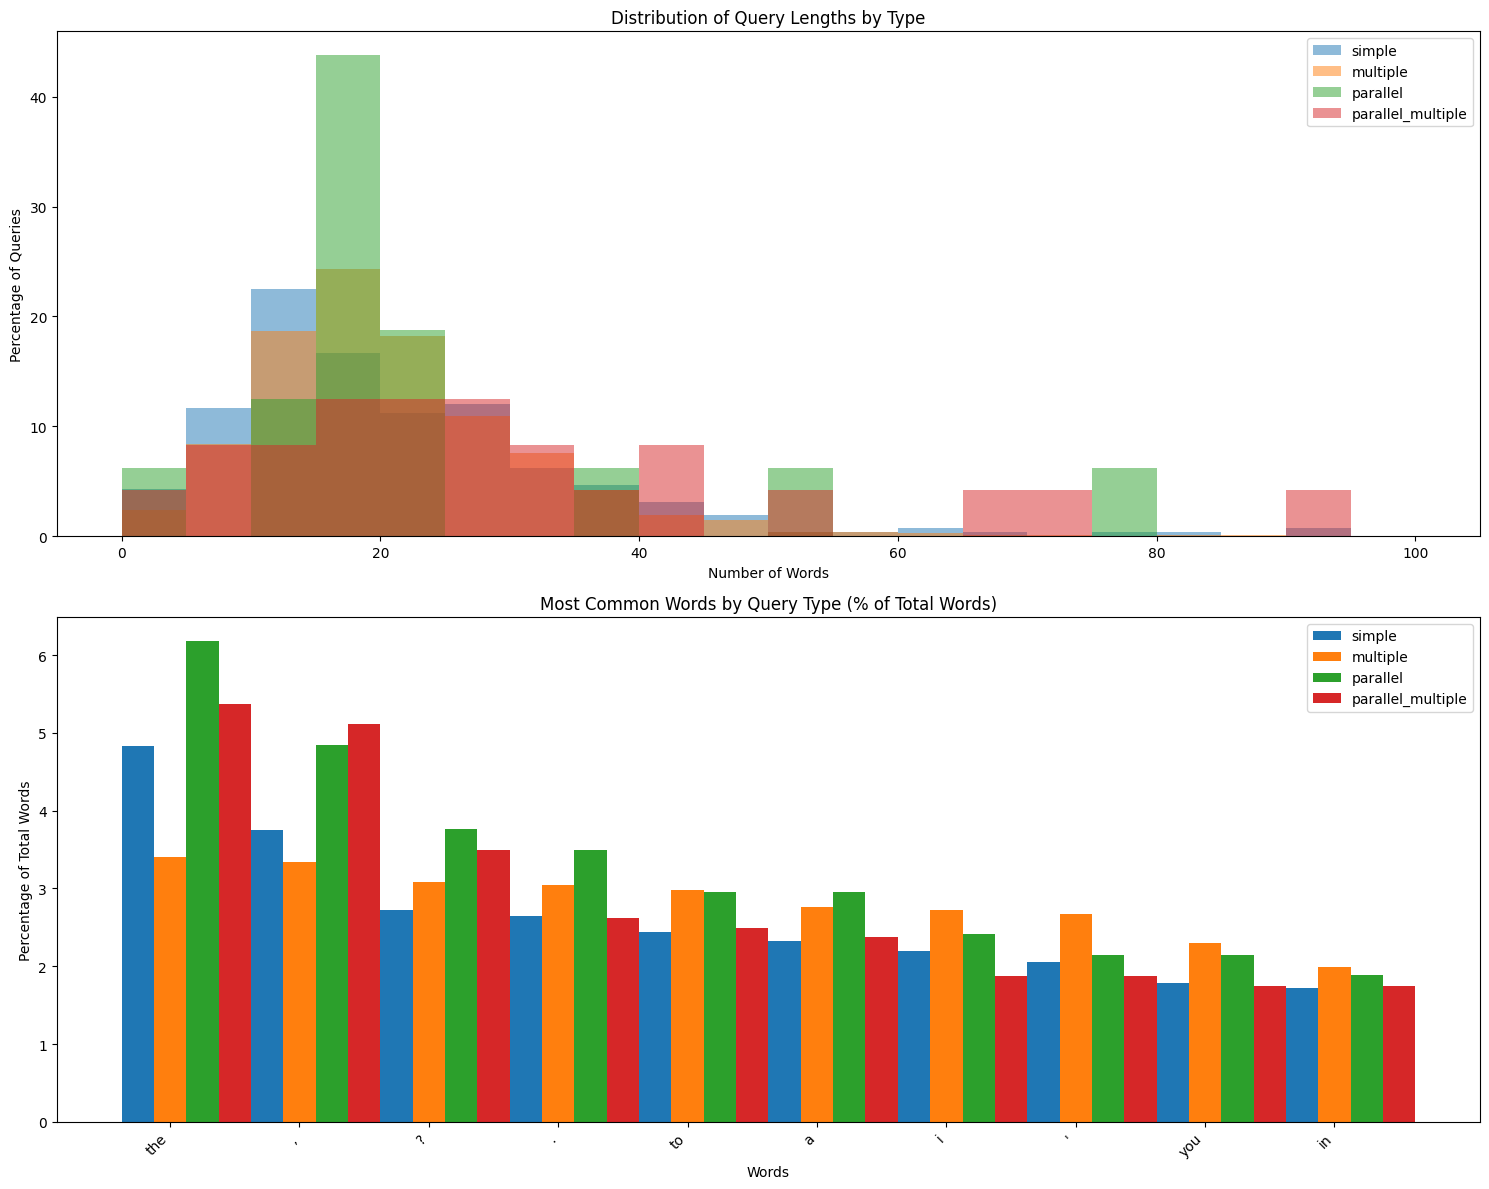

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

def get_bfcl_question(item):
    question = item['question'][0][-1]
    assert len(question) <= 2, f"There should be only one question in the data, but got {len(question)}, {question}"
    return question['content']

# Analyze queries for all types
data_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']
queries_by_type = {
    type_: [get_bfcl_question(item) for item in real_data[type_]]
    for type_ in data_types
}

# Create subplots for length distribution and word frequency
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Query length distributions
for type_ in data_types:
    query_lengths = [len(word_tokenize(query)) for query in queries_by_type[type_]]
    # Convert to percentages by normalizing by total count
    weights = np.ones_like(query_lengths) / len(query_lengths) * 100
    axes[0].hist(query_lengths, bins=20, alpha=0.5, label=type_, range=(0, 100), weights=weights)

axes[0].set_title('Distribution of Query Lengths by Type')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Percentage of Queries')
axes[0].legend()

# Plot 2: Most common words comparison
word_freq_by_type = {}
for type_ in data_types:
    # Count total words for this type
    all_words = [word.lower() for query in queries_by_type[type_] 
                 for word in word_tokenize(query)]
    total_words = len(all_words)
    
    # Get frequencies and convert to percentages
    word_counts = Counter(all_words).most_common(10)
    word_freq_by_type[type_] = [(word, (count/total_words)*100) for word, count in word_counts]

x = np.arange(10)
width = 0.25
for i, type_ in enumerate(data_types):
    axes[1].bar(x + i*width, 
                [percentage for word, percentage in word_freq_by_type[type_]], 
                width, 
                label=type_)
    if i == 0:
        axes[1].set_xticks(x + width)
        axes[1].set_xticklabels([word for word, _ in word_freq_by_type[type_]], 
                               rotation=45, 
                               ha='right')

axes[1].set_title('Most Common Words by Query Type (% of Total Words)')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Percentage of Total Words')
axes[1].legend()

plt.tight_layout()
plt.show()

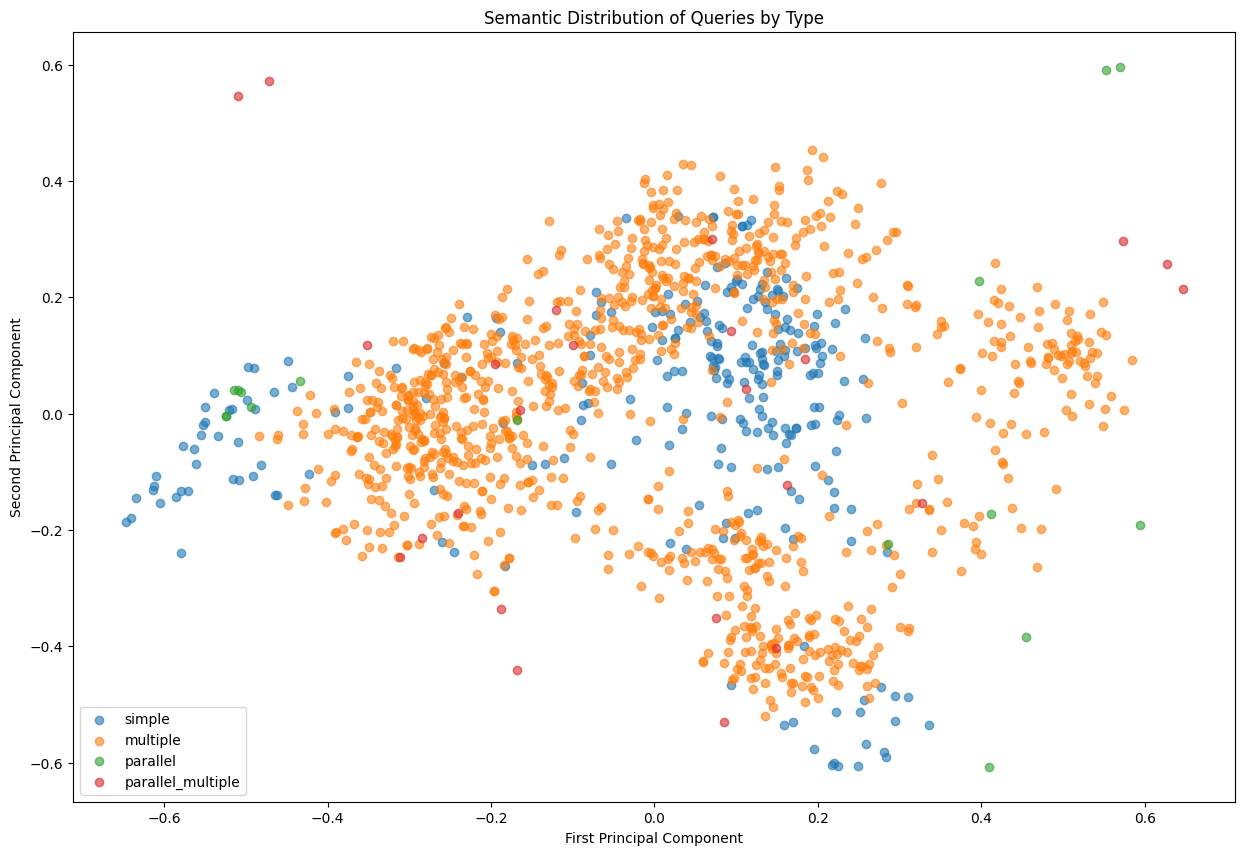

In [5]:
# 2. from the semantic perspective
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create plots for each type
plt.figure(figsize=(15, 10))

for type_name, queries in queries_by_type.items():
    # Get embeddings for this type's queries
    type_embeddings = model.encode(queries)
    
    # Reduce dimensionality with PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(type_embeddings)
    
    # Plot with different color/marker for each type
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
               alpha=0.6, label=type_name)

plt.title('Semantic Distribution of Queries by Type')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

#### APIGen Data (i.e., synthesized data)

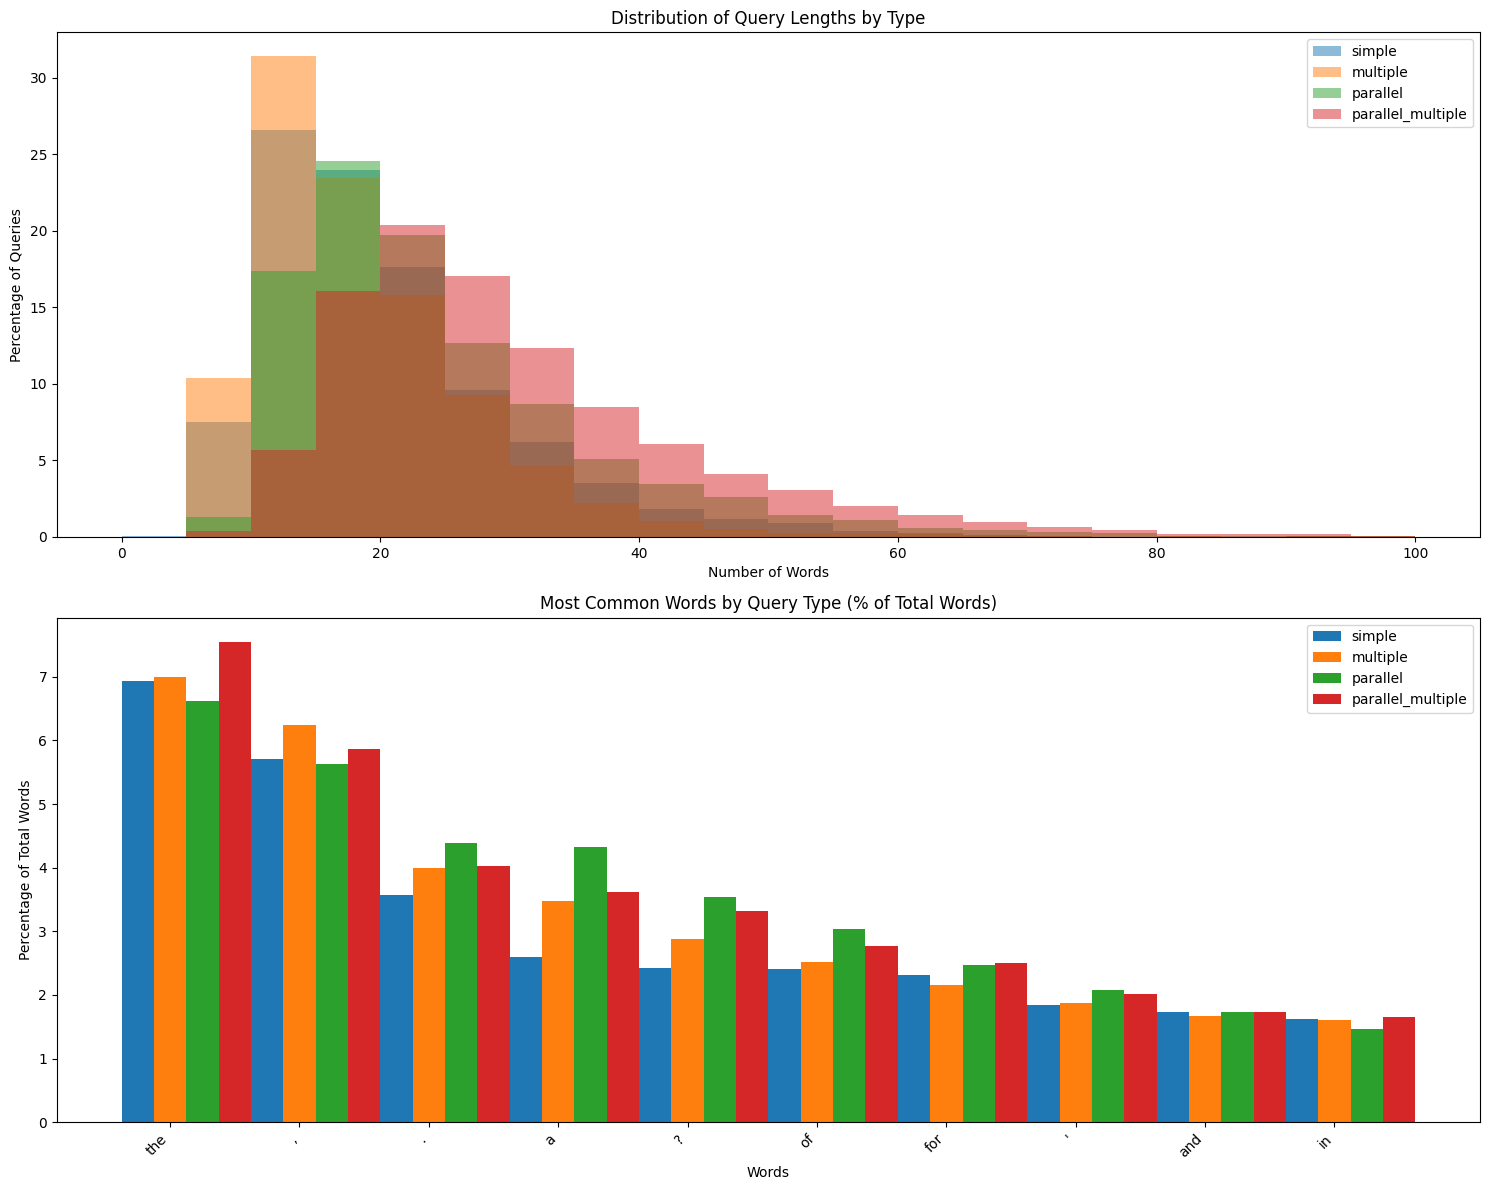

In [6]:
# Do the same thing for apigen data

def get_apigen_question(item):
    question = item['query']
    return question

# Analyze queries for all types
data_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']
queries_by_type = {
    type_: [get_apigen_question(item) for item in apigen_datasets_classified[type_]]
    for type_ in data_types
}

# Create subplots for length distribution and word frequency
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Query length distributions
for type_ in data_types:
    query_lengths = [len(word_tokenize(query)) for query in queries_by_type[type_]]
    # Convert to percentages by normalizing by total count
    weights = np.ones_like(query_lengths) / len(query_lengths) * 100
    axes[0].hist(query_lengths, bins=20, alpha=0.5, label=type_, range=(0, 100), weights=weights)

axes[0].set_title('Distribution of Query Lengths by Type')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Percentage of Queries')
axes[0].legend()

# Plot 2: Most common words comparison
word_freq_by_type = {}
for type_ in data_types:
    # Count total words for this type
    all_words = [word.lower() for query in queries_by_type[type_] 
                 for word in word_tokenize(query)]
    total_words = len(all_words)
    
    # Get frequencies and convert to percentages
    word_counts = Counter(all_words).most_common(10)
    word_freq_by_type[type_] = [(word, (count/total_words)*100) for word, count in word_counts]

x = np.arange(10)
width = 0.25
for i, type_ in enumerate(data_types):
    axes[1].bar(x + i*width, 
                [percentage for word, percentage in word_freq_by_type[type_]], 
                width, 
                label=type_)
    if i == 0:
        axes[1].set_xticks(x + width)
        axes[1].set_xticklabels([word for word, _ in word_freq_by_type[type_]], 
                               rotation=45, 
                               ha='right')

axes[1].set_title('Most Common Words by Query Type (% of Total Words)')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Percentage of Total Words')
axes[1].legend()

plt.tight_layout()
plt.show()

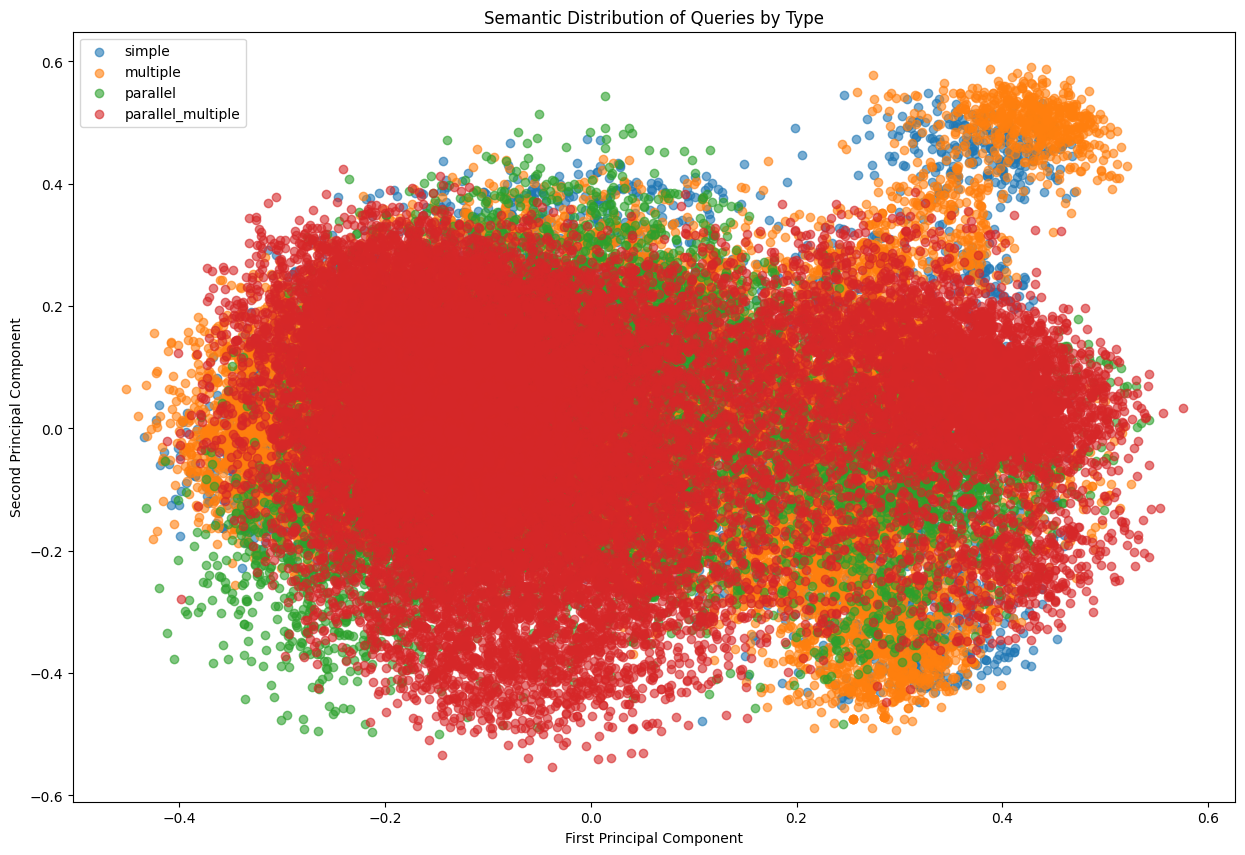

In [7]:
# 2. from the semantic perspective
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create plots for each type
plt.figure(figsize=(15, 10))

for type_name, queries in queries_by_type.items():
    # Get embeddings for this type's queries
    type_embeddings = model.encode(queries)
    
    # Reduce dimensionality with PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(type_embeddings)
    
    # Plot with different color/marker for each type
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
               alpha=0.6, label=type_name)

plt.title('Semantic Distribution of Queries by Type')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

#### Side by side comparison between real data and apigen data

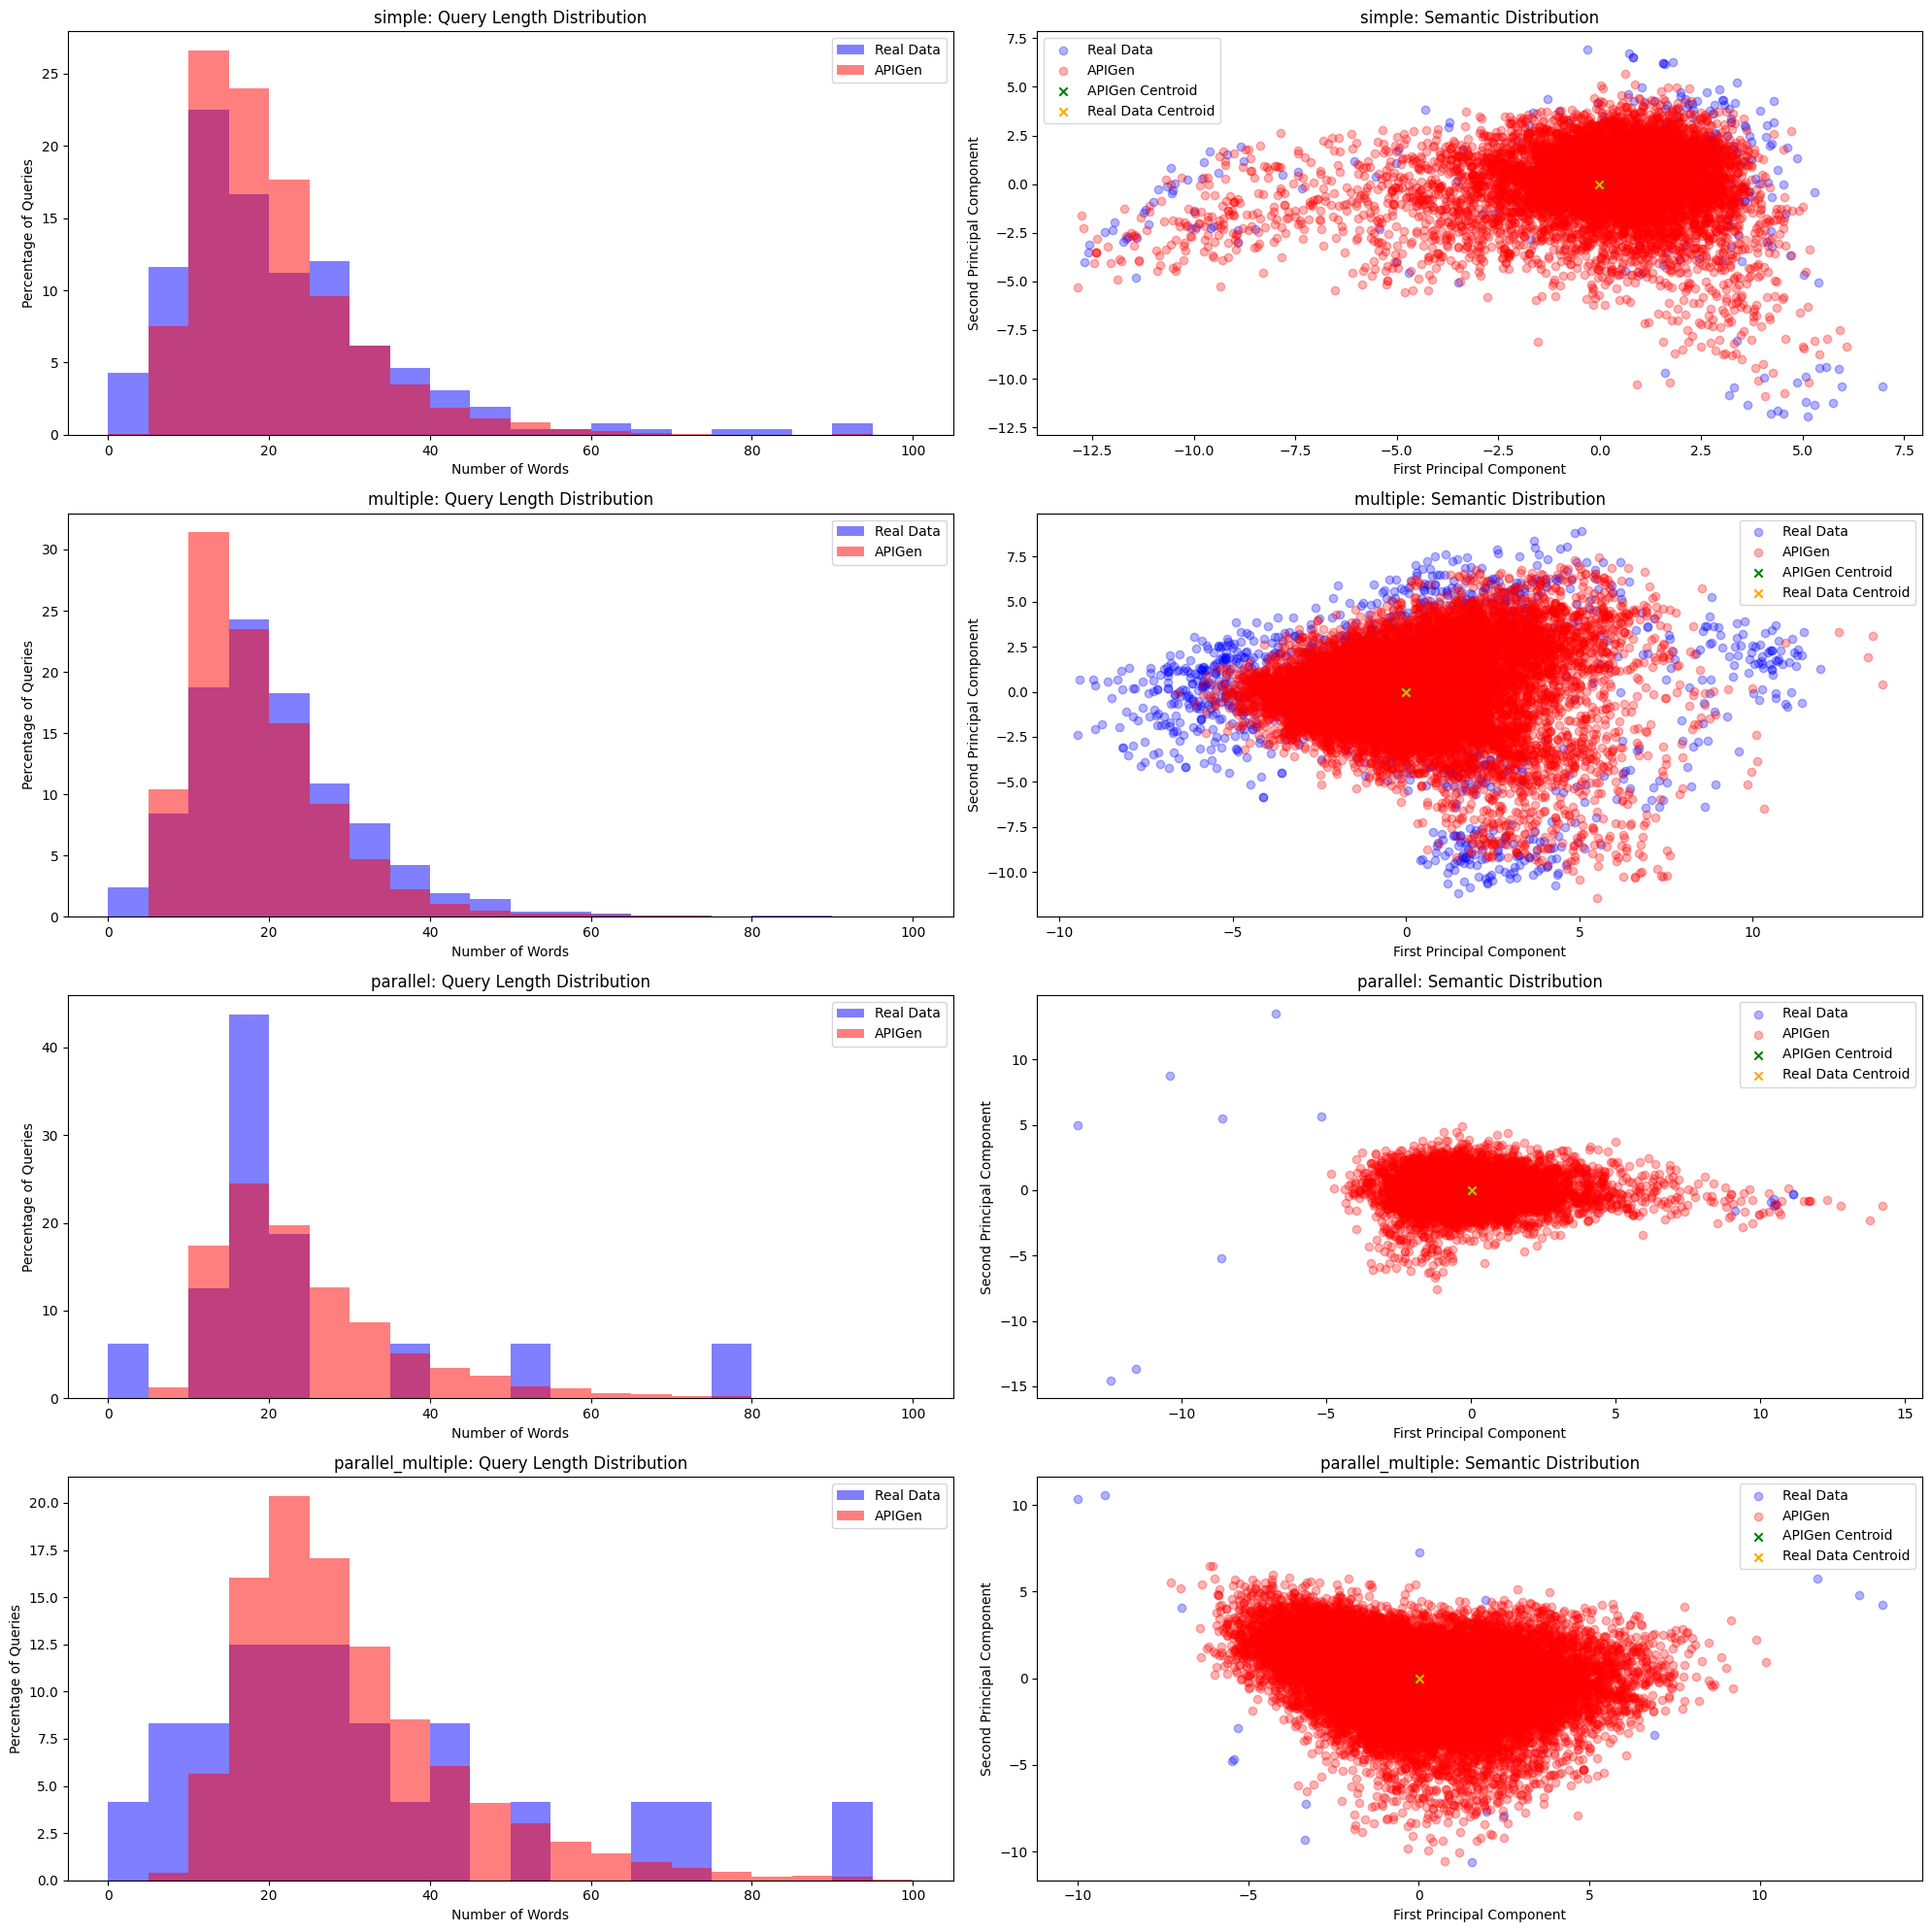

In [49]:
# Function to get questions from both datasets
def get_bfcl_question(item):
    question = item['question'][0][-1]
    assert len(question) <= 2, f"There should be only one question in the data, but got {len(question)}, {question}"
    return question['content']

def get_apigen_question(item):
    return item['query']

# Create side-by-side comparison for each type
data_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']

# Load model for embedding
model = SentenceTransformer('all-MiniLM-L6-v2')

# Setup the plots
fig, axes = plt.subplots(len(data_types), 2, figsize=(20, 5*len(data_types)))

# store all queries, key is the type
real_queries_all = {}
apigen_queries_all = {}

# store all embeddings and 2d embeddings, key is the type
real_embeddings_all = {}
apigen_embeddings_all = {}
real_2d_all = {}
apigen_2d_all = {}

for idx, type_ in enumerate(data_types):
    # Get queries for both datasets
    real_queries = [get_bfcl_question(item) for item in real_data[type_]]
    apigen_queries = [get_apigen_question(item) for item in apigen_datasets_classified[type_]]


    # storing all queries
    real_queries_all[type_] = real_queries
    apigen_queries_all[type_] = apigen_queries

    # Plot 1: Query length distributions
    real_lengths = [len(word_tokenize(query)) for query in real_queries]
    apigen_lengths = [len(word_tokenize(query)) for query in apigen_queries]
    
    # Convert to percentages by normalizing
    real_weights = np.ones_like(real_lengths) / len(real_lengths) * 100
    apigen_weights = np.ones_like(apigen_lengths) / len(apigen_lengths) * 100
    
    axes[idx, 0].hist(real_lengths, bins=20, alpha=0.5, label='Real Data', 
                      range=(0, 100), color='blue', weights=real_weights)
    axes[idx, 0].hist(apigen_lengths, bins=20, alpha=0.5, label='APIGen', 
                      range=(0, 100), color='red', weights=apigen_weights)
    axes[idx, 0].set_title(f'{type_}: Query Length Distribution')
    axes[idx, 0].set_xlabel('Number of Words')
    axes[idx, 0].set_ylabel('Percentage of Queries')
    axes[idx, 0].legend()
    
    # Plot 2: Semantic Distribution
    real_embeddings = model.encode(real_queries)
    apigen_embeddings = model.encode(apigen_queries)
    
    # reduce the dimensionality, before PCA, we standardize the embeddings, we use epsilon to avoid division by zero
    real_embeddings_standardized = (real_embeddings - np.mean(real_embeddings, axis=0)) / (np.std(real_embeddings, axis=0) + 1e-6)
    apigen_embeddings_standardized = (apigen_embeddings - np.mean(apigen_embeddings, axis=0)) / (np.std(apigen_embeddings, axis=0) + 1e-6)

    pca = PCA(n_components=2)
    real_2d = pca.fit_transform(real_embeddings_standardized)
    apigen_2d = pca.transform(apigen_embeddings_standardized)

    # storing all embeddings and 2d embeddings
    real_embeddings_all[type_] = real_embeddings_standardized
    apigen_embeddings_all[type_] = apigen_embeddings_standardized
    real_2d_all[type_] = real_2d
    apigen_2d_all[type_] = apigen_2d

    # plotting, we also plot the centroid of the apigen data and the real data
    axes[idx, 1].scatter(real_2d[:, 0], real_2d[:, 1], alpha=0.3, label='Real Data', color='blue')
    axes[idx, 1].scatter(apigen_2d[:, 0], apigen_2d[:, 1], alpha=0.3, label='APIGen', color='red')
    axes[idx, 1].set_title(f'{type_}: Semantic Distribution')
    axes[idx, 1].set_xlabel('First Principal Component')
    axes[idx, 1].set_ylabel('Second Principal Component')
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()

There are many real data items that are far away from the apigen data, we can look at the farthest ones from the centroid of the apigen data

In [73]:
DATA_TYPE = 'parallel_multiple'
TOP_K = 5
# we don't need to compute the distance of each real data item to the centroid of the apigen data
# because the centroid of standardized data is 0

# distance is just the norm of the 2d embedding
real_data_distances = [np.linalg.norm(embedding) for embedding in real_2d_all[DATA_TYPE]]

# choose the top 10 real data with the largest distance
farthest_real_data = np.argsort(real_data_distances)[-TOP_K:][::-1]

# choose the top 10 real data with the smallest distance
closest_real_data = np.argsort(real_data_distances)[:TOP_K]

print('farthest real data:')
for idx in farthest_real_data:
    print(real_queries_all[DATA_TYPE][idx], end='\n-----------------------------------\n')

print('closest real data:')
for idx in closest_real_data:
    print(real_queries_all[DATA_TYPE][idx], end='\n-----------------------------------\n')


farthest real data:
Find the highest common factor for 36 and 48, and then tell me how steep the curve of the function f(x) = x^2 is at x = 5?
-----------------------------------
Find any music or theater events happening in San Diego, CA on March 1st 2023?
-----------------------------------
Can you first calculate the greatest common divisor of the numbers 36 and 48 and then estimate the derivative of the function f(x) = x^2 at the point x = 5?
-----------------------------------
Find any music concerts or theater plays happening in Los Angeles on March 10th? this year is 2023
-----------------------------------
I need to set up reservations for my upcoming trip and really need your help to get this done with a minimal amount of stress. Can you find a music event happening in New York on 2023-05-21? Also, I'm traveling from Boston, MA to New York by bus on the same date. Could you search for a direct bus itinerary for 2 people?
-----------------------------------
closest real data:
I

#### Function statistics
For function statistics, we will look at the number of functions in the query, and the distribution of the number of functions in the query.

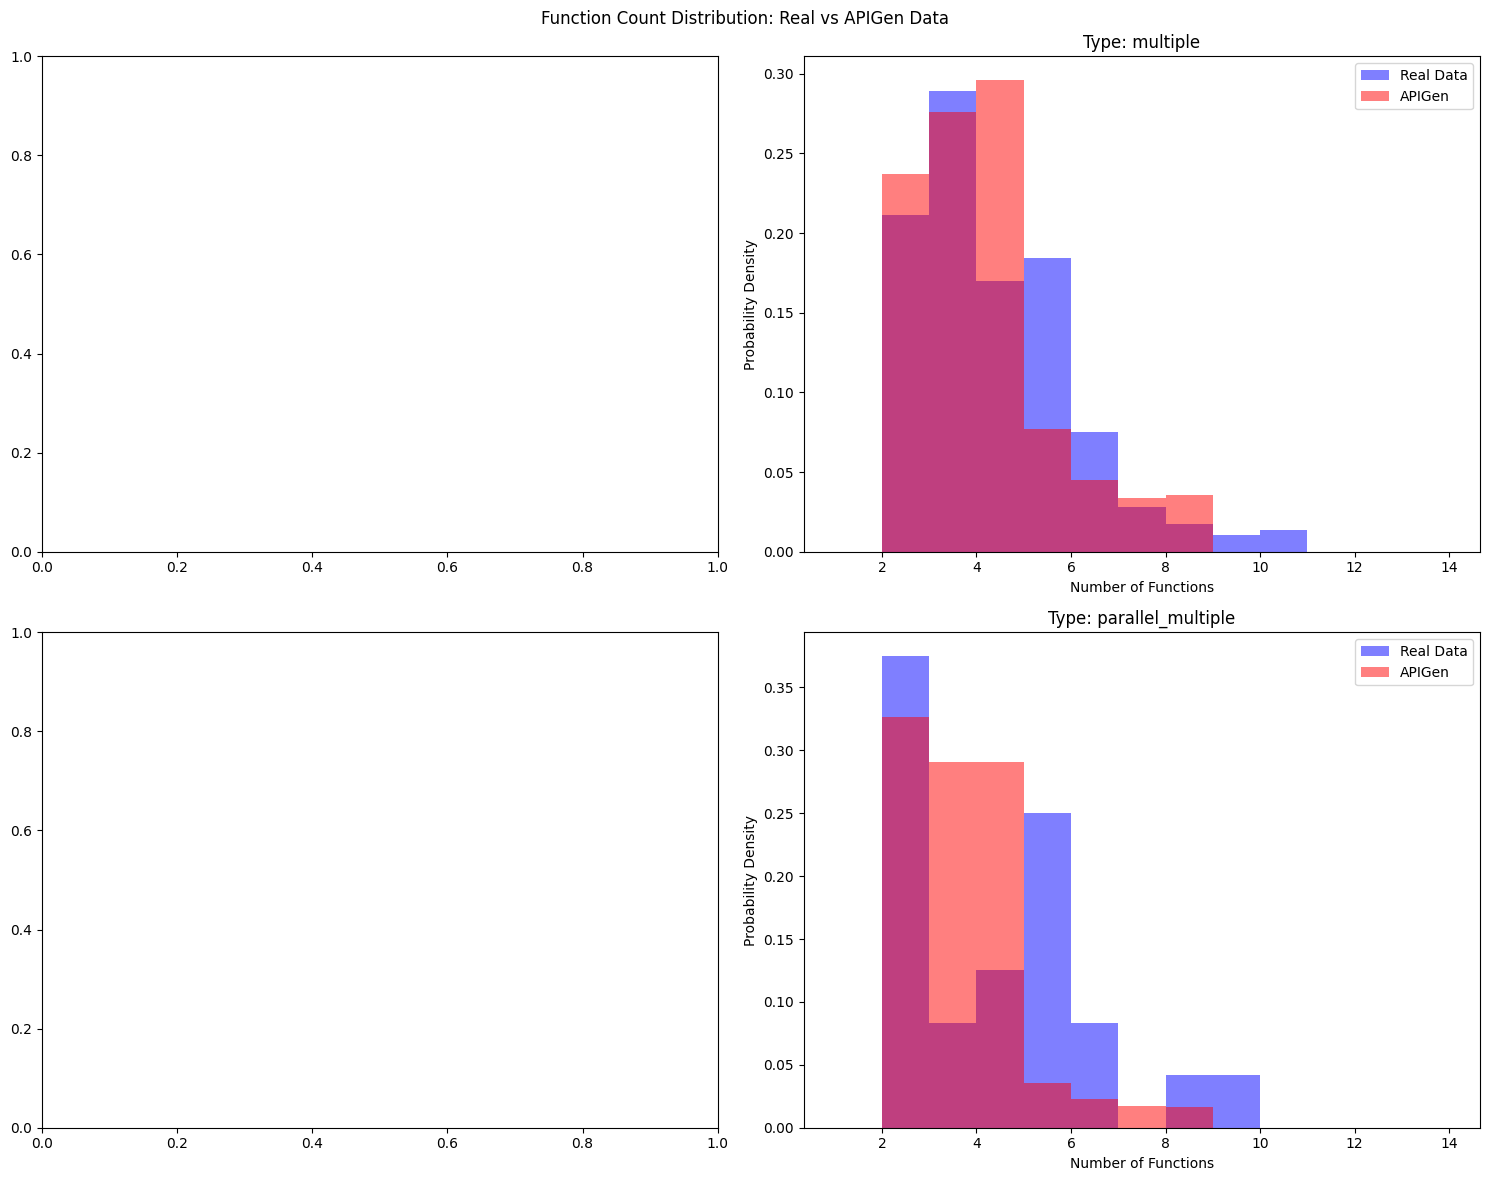

In [9]:
from scipy.stats import gaussian_kde

# Function to count functions in real data
def count_real_functions(item):
    return len(item['function'])

# Function to count functions in apigen data
def count_apigen_functions(item):
    answers = json.loads(item['tools'])
    return len(answers)

# Get function counts for both datasets
real_function_counts = {
    type_: [count_real_functions(item) for item in data]
    for type_, data in real_data.items()
}

apigen_function_counts = {
    type_: [count_apigen_functions(item) for item in data]
    for type_, data in apigen_datasets_classified.items()
}

# ... existing imports and function definitions ...

# Create subplot grid
multiple_bins = range(1, 15, 1)
skip_types = ['simple', 'parallel']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Function Count Distribution: Real vs APIGen Data')



# Plot histograms for each type
for idx, type_ in enumerate(data_types):
    if type_ in skip_types:
        continue
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Calculate normalized histograms (PDF)
    real_hist, real_bins = np.histogram(real_function_counts[type_], bins=20, density=True)
    apigen_hist, apigen_bins = np.histogram(apigen_function_counts[type_], bins=20, density=True)
    
    # Plot histograms
    if 'multiple' in type_:
        ax.hist(real_function_counts[type_], bins=multiple_bins, alpha=0.5, 
                label='Real Data', color='blue', density=True)
        ax.hist(apigen_function_counts[type_], bins=multiple_bins, alpha=0.5, 
                label='APIGen', color='red', density=True)
    else:
        ax.hist(real_function_counts[type_], bins=5, alpha=0.5, 
                label='Real Data', color='blue', density=True)
        ax.hist(apigen_function_counts[type_], bins=5, alpha=0.5, 
                label='APIGen', color='red', density=True)
    
    ax.set_title(f'Type: {type_}')
    ax.set_xlabel('Number of Functions')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.tight_layout()

#### Function call answer statistics
For function call answer statistics, we will look at:
1. the number of function calls in the answer
2. the number of arguments in the function call

In [10]:
# synthetic data
json.loads(apigen_datasets_classified['parallel'][0]['answers'])

[{'name': 'live_giveaways_by_type', 'arguments': {'type': 'beta'}},
 {'name': 'live_giveaways_by_type', 'arguments': {'type': 'game'}}]

In [11]:
# real data
real_data_answers['simple'][0]['ground_truth']

[{'get_user_info': {'user_id': [7890], 'special': ['black']}}]


Function call statistics for simple:
Synthetic - Mean: 1.00, Median: 1.00
Real - Mean: 1.00, Median: 1.00

Argument statistics for simple:
Synthetic - Mean: 2.00, Median: 2.00
Real - Mean: 2.76, Median: 2.00

Function call statistics for multiple:
Synthetic - Mean: 1.00, Median: 1.00
Real - Mean: 1.00, Median: 1.00

Argument statistics for multiple:
Synthetic - Mean: 1.96, Median: 2.00
Real - Mean: 3.83, Median: 3.00

Function call statistics for parallel:
Synthetic - Mean: 2.34, Median: 2.00
Real - Mean: 2.44, Median: 2.00

Argument statistics for parallel:
Synthetic - Mean: 1.49, Median: 1.00
Real - Mean: 2.85, Median: 2.00

Function call statistics for parallel_multiple:
Synthetic - Mean: 2.25, Median: 2.00
Real - Mean: 2.29, Median: 2.00

Argument statistics for parallel_multiple:
Synthetic - Mean: 1.59, Median: 1.00
Real - Mean: 2.64, Median: 3.00


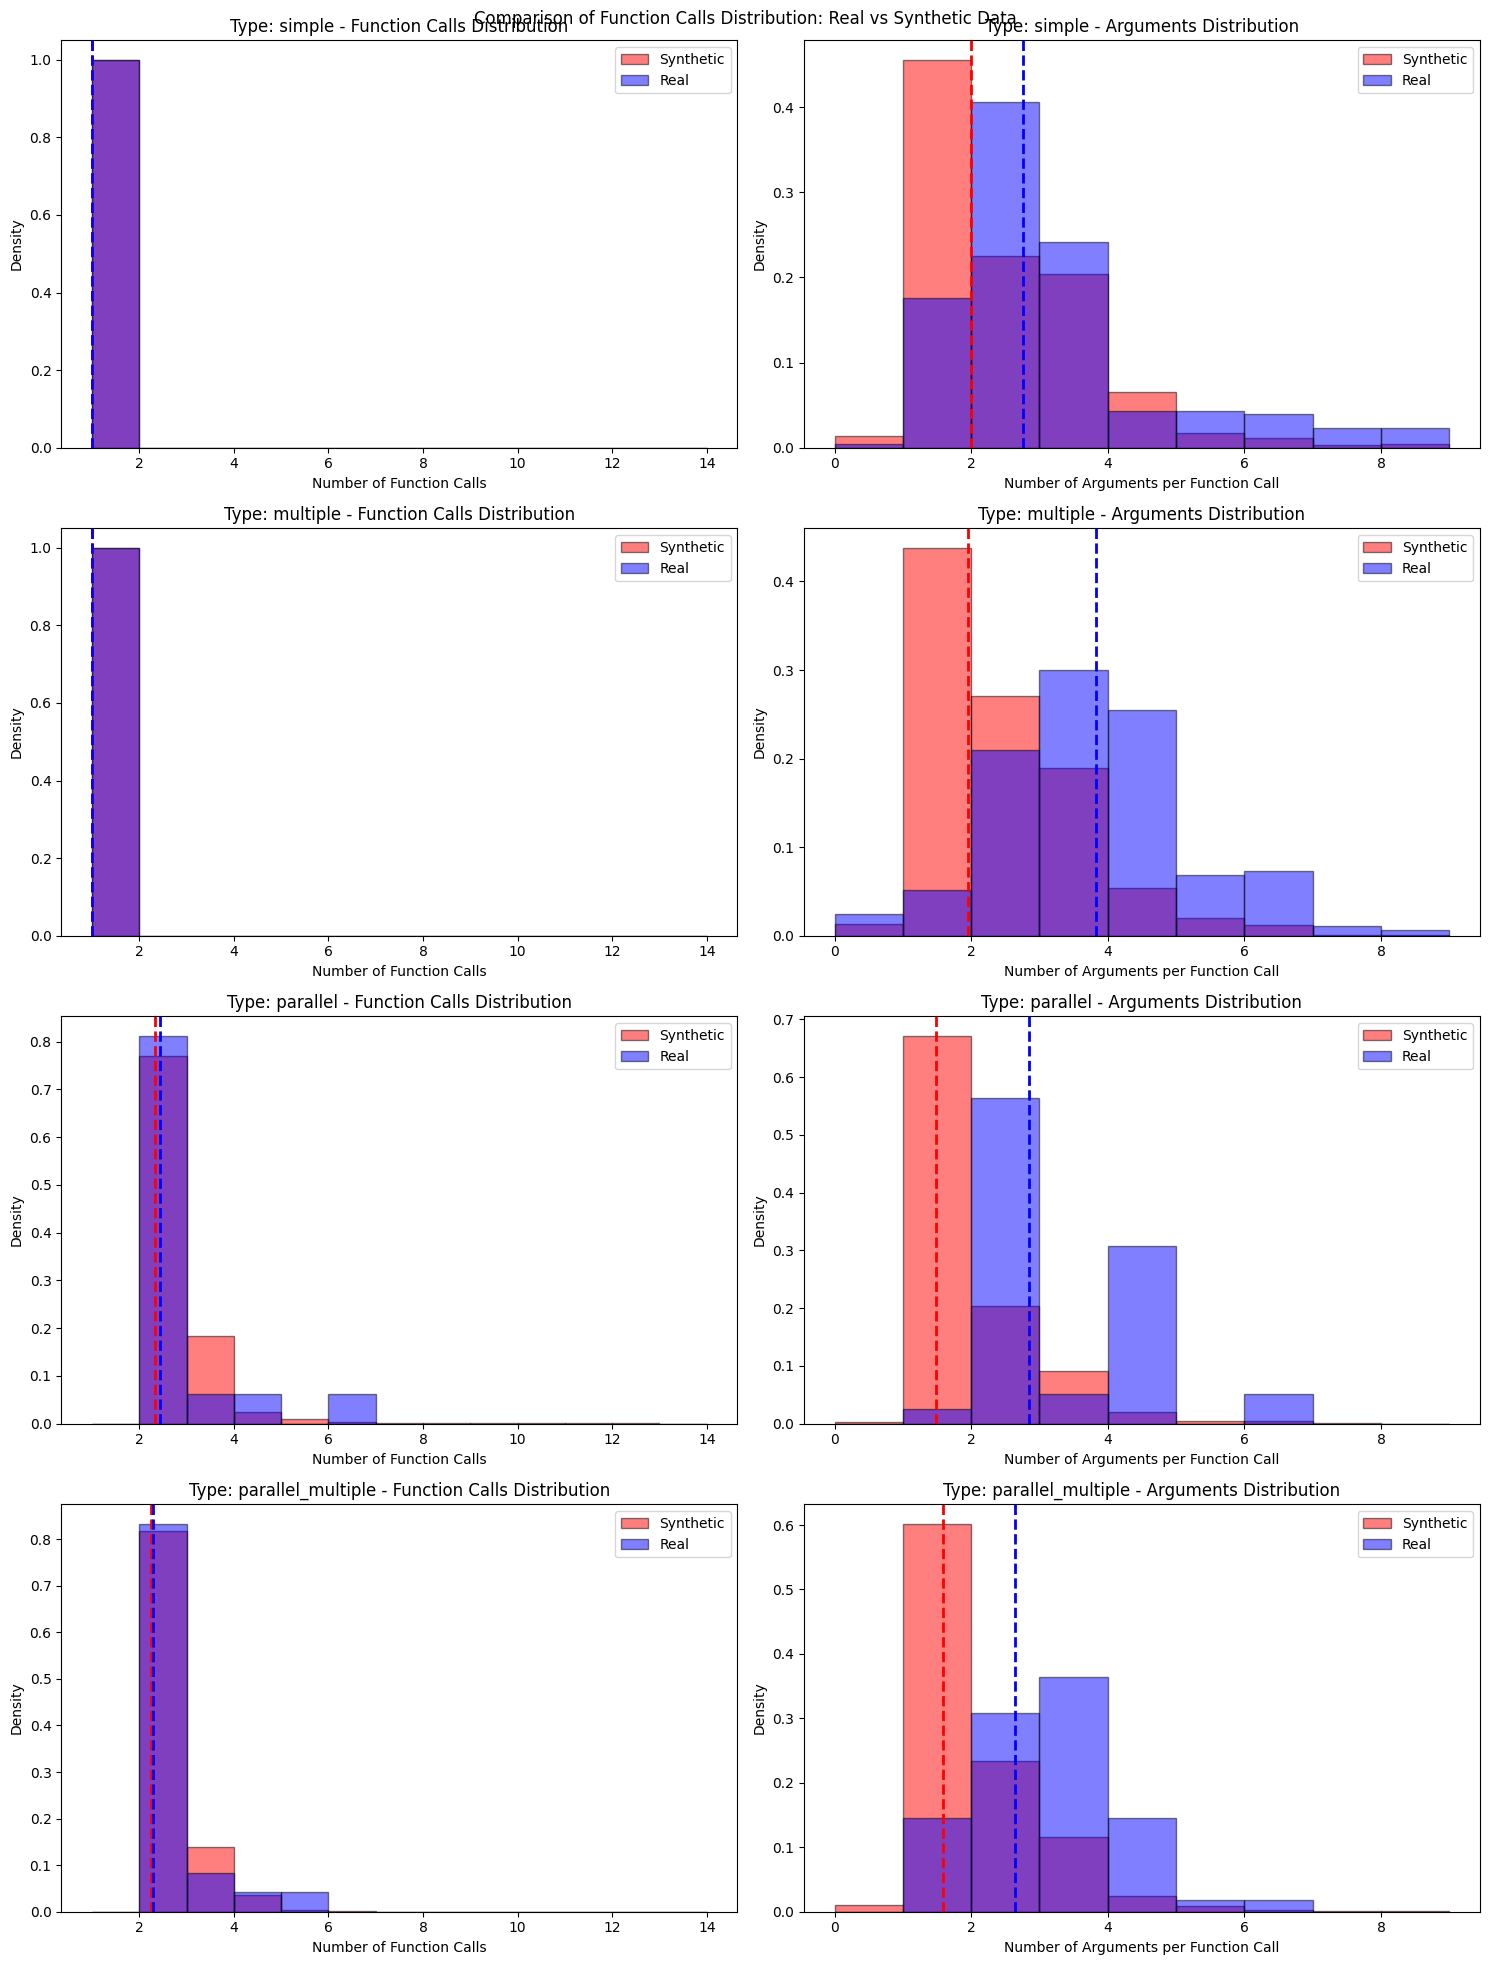

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Create subplot for analyzing function calls in all types
split_types = ['simple', 'multiple', 'parallel', 'parallel_multiple']
fig, axes = plt.subplots(4, 2, figsize=(15, 20))  # Changed to 4x2 layout
fig.suptitle('Comparison of Function Calls Distribution: Real vs Synthetic Data')

for idx, type_ in enumerate(split_types):
    # Count function calls for synthetic data
    synthetic_num_calls = [len(json.loads(item['answers'])) 
                          for item in apigen_datasets_classified[type_]]
    
    # Count function calls for real data
    real_num_calls = [len(item['ground_truth']) 
                     for item in real_data_answers[type_]]
    
    # Plot function calls distribution
    ax = axes[idx, 0]  # Changed indexing for 4x2 layout
    ax.hist(synthetic_num_calls, bins=range(1, 15, 1), alpha=0.5, 
            color='red', edgecolor='black', label='Synthetic', density=True)
    ax.hist(real_num_calls, bins=range(1, 15, 1), alpha=0.5, 
            color='blue', edgecolor='black', label='Real', density=True)
    
    ax.set_title(f'Type: {type_} - Function Calls Distribution')
    ax.set_xlabel('Number of Function Calls')
    ax.set_ylabel('Density')
    ax.legend()
    
    # Add mean lines
    synthetic_mean = np.mean(synthetic_num_calls)
    real_mean = np.mean(real_num_calls)
    ax.axvline(synthetic_mean, color='red', linestyle='dashed', linewidth=2)
    ax.axvline(real_mean, color='blue', linestyle='dashed', linewidth=2)
    
    # Print statistics
    print(f"\nFunction call statistics for {type_}:")
    print(f"Synthetic - Mean: {synthetic_mean:.2f}, Median: {np.median(synthetic_num_calls):.2f}")
    print(f"Real - Mean: {real_mean:.2f}, Median: {np.median(real_num_calls):.2f}")

    # Count arguments for synthetic data
    synthetic_num_args = []
    for item in apigen_datasets_classified[type_]:
        answers = json.loads(item['answers'])
        for answer in answers:
            synthetic_num_args.append(len(answer['arguments']))
    
    # Count arguments for real data
    real_num_args = []
    for item in real_data_answers[type_]:
        for answer in item['ground_truth']:
            # Get the first (and only) function name and its arguments
            func_name = list(answer.keys())[0]
            real_num_args.append(len(answer[func_name]))
    
    # Plot arguments distribution
    ax = axes[idx, 1]  # Changed indexing for 4x2 layout
    ax.hist(synthetic_num_args, bins=range(0, 10, 1), alpha=0.5,
            color='red', edgecolor='black', label='Synthetic', density=True)
    ax.hist(real_num_args, bins=range(0, 10, 1), alpha=0.5,
            color='blue', edgecolor='black', label='Real', density=True)
    
    ax.set_title(f'Type: {type_} - Arguments Distribution')
    ax.set_xlabel('Number of Arguments per Function Call')
    ax.set_ylabel('Density')
    ax.legend()
    
    # Add mean lines
    synthetic_mean_args = np.mean(synthetic_num_args)
    real_mean_args = np.mean(real_num_args)
    ax.axvline(synthetic_mean_args, color='red', linestyle='dashed', linewidth=2)
    ax.axvline(real_mean_args, color='blue', linestyle='dashed', linewidth=2)
    
    # Print statistics
    print(f"\nArgument statistics for {type_}:")
    print(f"Synthetic - Mean: {synthetic_mean_args:.2f}, Median: {np.median(synthetic_num_args):.2f}")
    print(f"Real - Mean: {real_mean_args:.2f}, Median: {np.median(real_num_args):.2f}")

plt.tight_layout()
plt.show()

### Hypothesis Testing


According to the above plots, we can see synthetic data has less function arguments per function call compared to real data. We hypothesize that this is because the LLM is not able to generate function calls with many arguments -> indicating APIs with more arguments are more difficult tasks for LLMs to generate or verify. More specifically, the research question is:
- Is it more challenging to invoke function calls that have more arguments? (therefore the associated task is more difficult)

To test this hypothesis, we would like to conduct the following experiments:
1. Test general language models’ performance on real data (because it’s unseen)
2. evaluate accuracy of tasks with different number of functions/arguments


Type: multiple
Low args (<=2): 287 items (27.7%)
Medium args (2-4): 557 items (53.7%)
High args (>4): 193 items (18.6%)


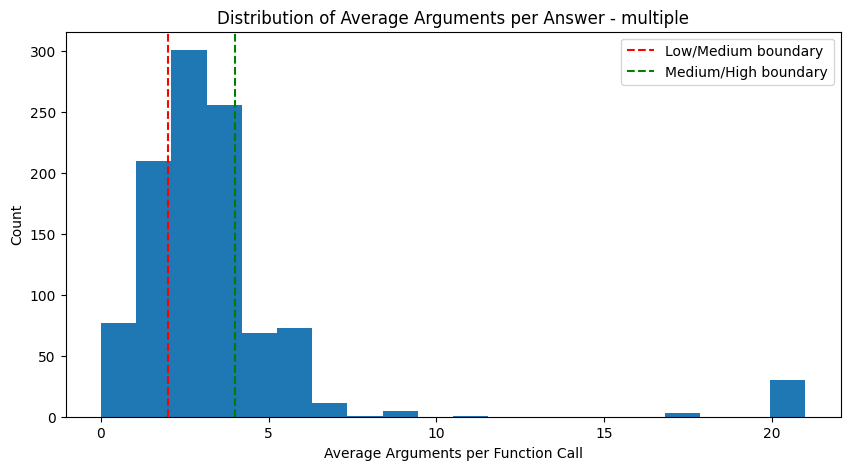


Type: simple
Low args (<=2): 150 items (58.1%)
Medium args (2-4): 73 items (28.3%)
High args (>4): 35 items (13.6%)


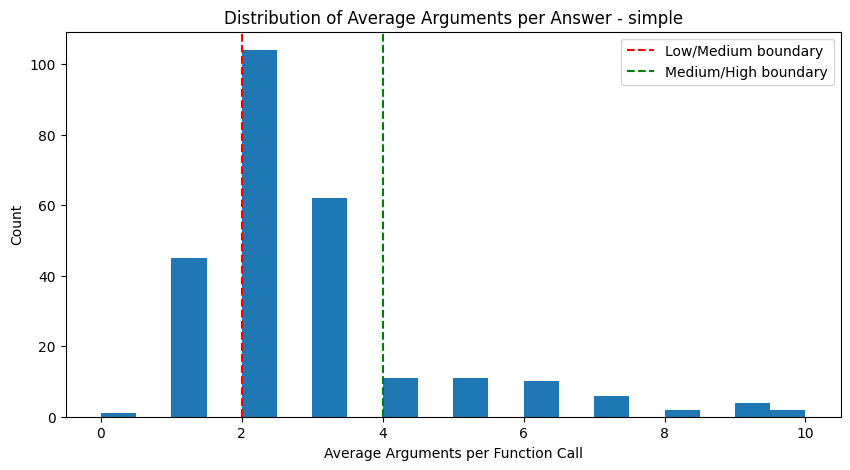


Type: parallel_multiple
Low args (<=2): 8 items (33.3%)
Medium args (2-4): 16 items (66.7%)
High args (>4): 0 items (0.0%)


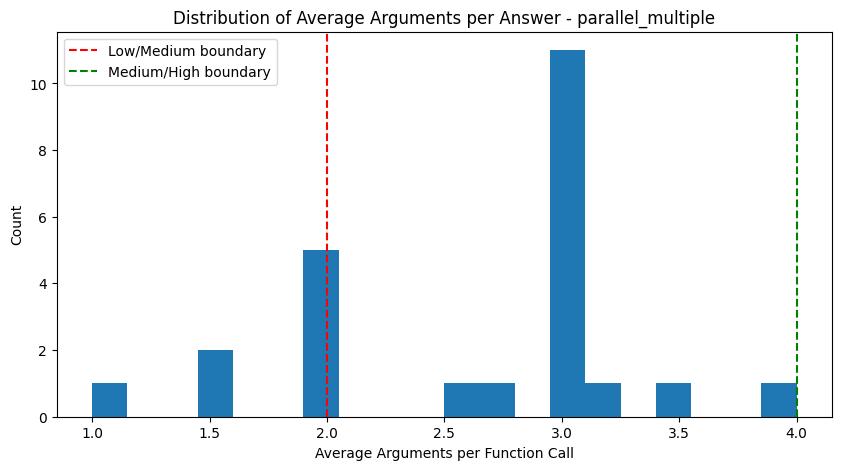


Type: parallel
Low args (<=2): 11 items (68.8%)
Medium args (2-4): 4 items (25.0%)
High args (>4): 1 items (6.2%)


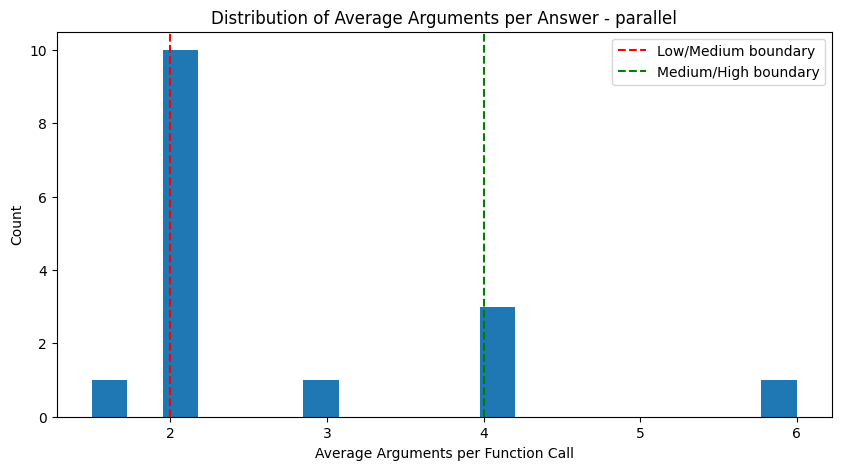

In [13]:
import matplotlib.pyplot as plt

LOWER_BOUND = 2
UPPER_BOUND = 4

# Function to calculate average arguments per answer
def get_avg_args_per_answer(item):
    total_args = 0
    num_functions = len(item['ground_truth'])
    
    for answer in item['ground_truth']:
        func_name = list(answer.keys())[0]
        total_args += len(answer[func_name])
    
    return total_args / num_functions

# Calculate statistics for each type
for type_ in real_data.keys():
    # Get average args for each item
    items_with_avg_args = [(item, get_avg_args_per_answer(item)) 
                          for item in real_data_answers[type_]]
    
    # Split into buckets: low (<=2), medium (2-4), high (>4) args
    low_args = [item for item, avg in items_with_avg_args if avg <= LOWER_BOUND]
    med_args = [item for item, avg in items_with_avg_args if LOWER_BOUND < avg <= UPPER_BOUND]
    high_args = [item for item, avg in items_with_avg_args if avg > UPPER_BOUND]
    
    print(f"\nType: {type_}")
    print(f"Low args (<={LOWER_BOUND}): {len(low_args)} items ({len(low_args)/len(items_with_avg_args)*100:.1f}%)")
    print(f"Medium args ({LOWER_BOUND}-{UPPER_BOUND}): {len(med_args)} items ({len(med_args)/len(items_with_avg_args)*100:.1f}%)")
    print(f"High args (>4): {len(high_args)} items ({len(high_args)/len(items_with_avg_args)*100:.1f}%)")

    # Optional: Plot distribution
    plt.figure(figsize=(10, 5))
    plt.hist([avg for _, avg in items_with_avg_args], bins=20)
    plt.title(f'Distribution of Average Arguments per Answer - {type_}')
    plt.xlabel('Average Arguments per Function Call')
    plt.ylabel('Count')
    plt.axvline(x=2, color='r', linestyle='--', label='Low/Medium boundary')
    plt.axvline(x=4, color='g', linestyle='--', label='Medium/High boundary')
    plt.legend()
    plt.show()

In [14]:
# join the real data answers and questions on 'id', add a new key "complexity" to indicate the average number of arguments per answer
def get_complexity(avg_args_per_answer, threshold_low=2, threshold_high=4):
    if avg_args_per_answer <= threshold_low:
        return 'low'
    elif avg_args_per_answer <= threshold_high:
        return 'medium'
    else:
        return 'high'


for type_ in real_data_answers.keys():
    for item in real_data_answers[type_]:
        item['avg_args_per_answer'] = get_avg_args_per_answer(item)
        # item['complexity'] = get_complexity(item['avg_args_per_answer'])
        item['number_of_functions'] = len(item['ground_truth'])

# make a dictionary to map the answer from id to ground_truth so we can join the real data and the answers on 'id'
answer_dict = {}
for type_ in real_data_answers.keys():
    answer_dict[type_] = {item['id']: item for item in real_data_answers[type_]}

# join the real data and the answers on 'id'
for type_ in real_data.keys():
    for item in real_data[type_]:
        mapped_answer_item = answer_dict[type_][item['id']]
        item['ground_truth'] = mapped_answer_item['ground_truth']
        # item['complexity'] = mapped_answer_item['complexity']
        item['avg_args_per_answer'] = mapped_answer_item['avg_args_per_answer']
        item['number_of_functions'] = mapped_answer_item['number_of_functions']


In [15]:
# # export the real data to a json file
# with open('real_data_with_answers.json', 'w') as f:
#     json.dump(real_data, f)

#### Load inference data to verify xLam-7b-fc-r

In [16]:
import json
import os
from glob import glob

with open('real_data_with_answers.json') as f:
    real_data = json.load(f)

INFERENCE_DATA_PATH_PATTERN = './Salesforce_xLAM-7b-fc-r/*.json'
def load_jsonl(path):
    # we load the json file as json lines
    # skip the first line
    result_dict = {}
    with open(path) as f:
        for line in f.readlines()[1:]:
            item = json.loads(line)
            result_dict[item['prompt']['id']] = item['valid']
    return result_dict

failed_inference_data = {os.path.basename(path).replace('_score.json', '').replace('BFCL_v3_live_', ''): 
                  load_jsonl(path) for path in glob(INFERENCE_DATA_PATH_PATTERN)}



In [17]:
# we join the failed inference data with real_data
for type_ in real_data.keys():
    for item in real_data[type_]:
        if item['id'] in failed_inference_data[type_]:
            item['valid'] = False
        else:
            item['valid'] = True

#### Accuracy by the average number of arguments in the answer

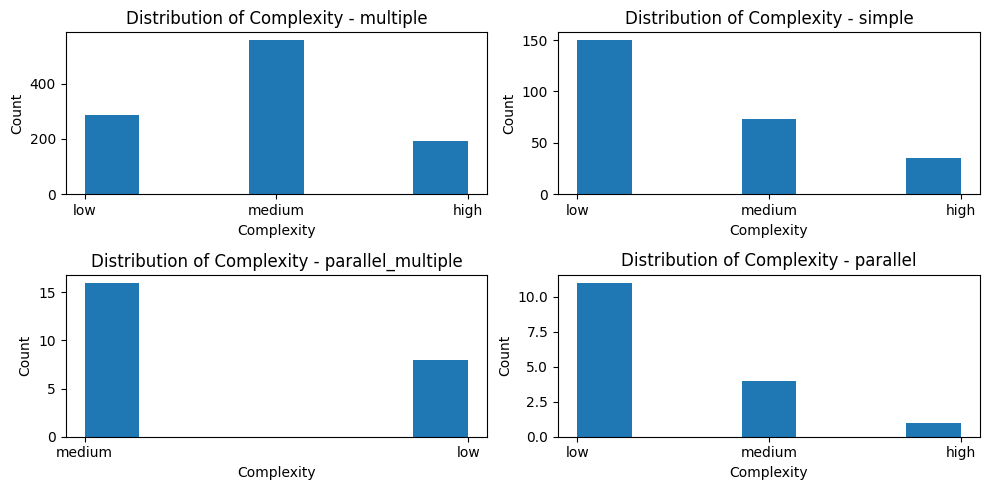

In [18]:
THRESHOLD_LOW = 2
THRESHOLD_HIGH = 4

# look at the distribution of the complexity for each type
hist_data = {}
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.ravel()  # Flatten axes array for easier indexing

for idx, type_ in enumerate(real_data.keys()):
    hist_data[type_] = [get_complexity(item['avg_args_per_answer'], THRESHOLD_LOW, THRESHOLD_HIGH) for item in real_data[type_]]
    axes[idx].hist(hist_data[type_], bins=7)
    axes[idx].set_title(f'Distribution of Complexity - {type_}')
    axes[idx].set_xlabel('Complexity')
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

As we can see, there are too few items in parallel_multiple and parallel types, we abandon these two types for the following analysis. We sample the simple and multiple types to the mean bin to make a fair comparison.

In [19]:
# we sample the data to the mean bin to make a fair comparison
np.random.seed(42)
sampled_real_data = {} # type_: bin
for type_ in real_data.keys():
    if type_ in ['parallel_multiple', 'parallel']:
        continue # we abandon these two types for the following analysis
    bin_counts = {}
    for complexity in ['low', 'medium', 'high']:
        bin_counts[complexity] = len([item for item in real_data[type_] if get_complexity(item['avg_args_per_answer'], THRESHOLD_LOW, THRESHOLD_HIGH) == complexity])
    mean_bin_count = int(np.mean(list(bin_counts.values())))
    sampled_real_data[type_] = np.random.choice(real_data[type_], mean_bin_count, replace=True)
    print(f"Sampled {type_} to {mean_bin_count} items")


Sampled multiple to 345 items
Sampled simple to 86 items


##### Distribution of accuracy by complexity (sampled)

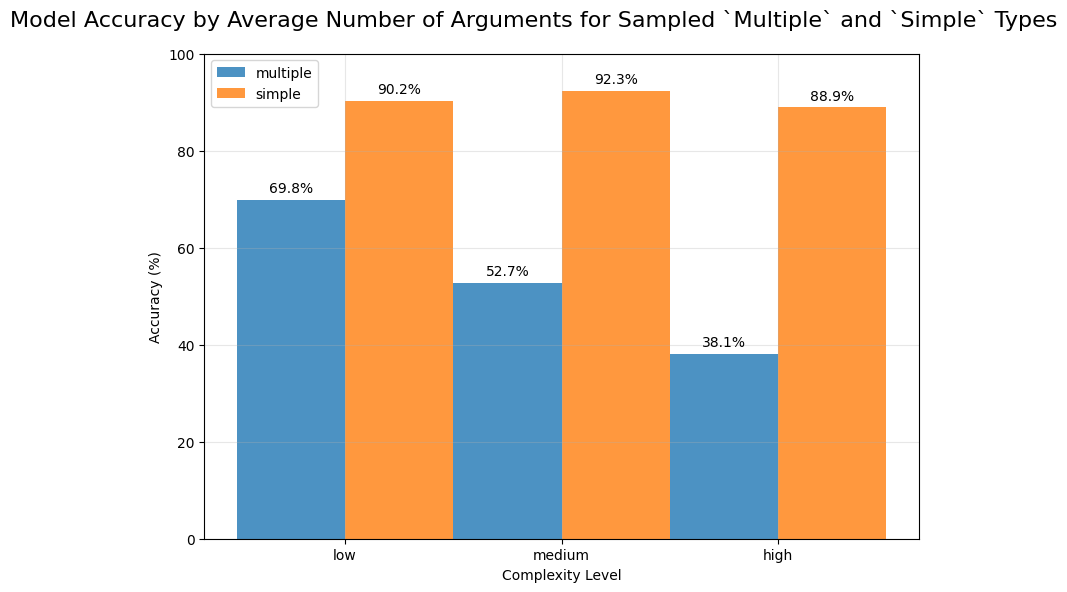

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate accuracy per complexity level for each type
accuracy_by_complexity = {}
for type_ in sampled_real_data.keys():
    complexity_groups = {}
    for item in sampled_real_data[type_]:
        complexity = get_complexity(item['avg_args_per_answer'], THRESHOLD_LOW, THRESHOLD_HIGH)
        valid = item['valid']
        if complexity not in complexity_groups:
            complexity_groups[complexity] = {'total': 0, 'valid': 0}
        complexity_groups[complexity]['total'] += 1
        if valid:
            complexity_groups[complexity]['valid'] += 1
    
    # Calculate accuracy percentages
    accuracies = {}
    for complexity, counts in complexity_groups.items():
        accuracies[complexity] = (counts['valid'] / counts['total']) * 100
    accuracy_by_complexity[type_] = accuracies

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle('Model Accuracy by Average Number of Arguments for Sampled `Multiple` and `Simple` Types', fontsize=16)

# Define fixed order for complexity levels
complexities = ['low', 'medium', 'high']
bar_width = 0.5
n_types = len(sampled_real_data.keys())
x = np.arange(len(complexities))

for idx, type_ in enumerate(sampled_real_data.keys()):
    accuracies = [accuracy_by_complexity[type_].get(c, 0) for c in complexities]
    
    # Create bar plot
    ax.bar(x + idx*bar_width, accuracies, bar_width, alpha=0.8, label=type_)
    
    # Add value labels on top of bars
    for i, v in enumerate(accuracies):
        ax.text(i + idx*bar_width, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Customize plot
ax.set_xlabel('Complexity Level')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x + bar_width * (n_types - 1) / 2)
ax.set_xticklabels(complexities)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()

##### Distribution of accuracy by complexity (not upsampled)

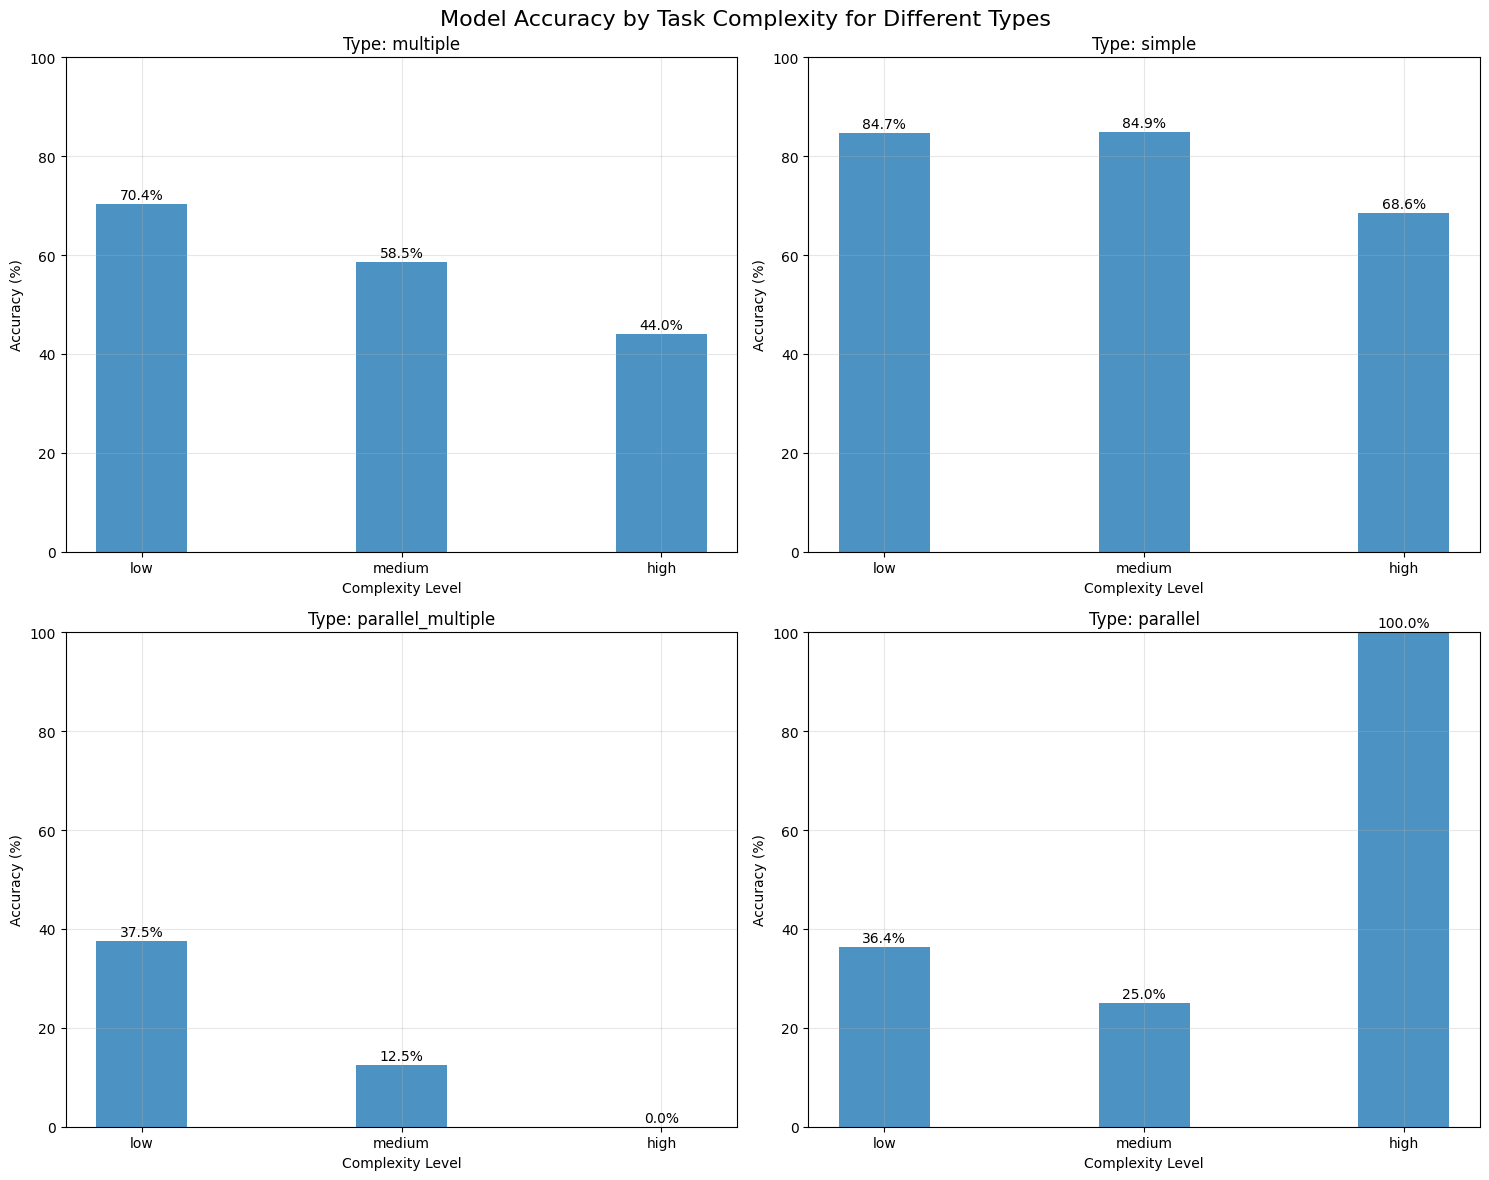

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate accuracy per complexity level for each type
accuracy_by_complexity = {}
for type_ in real_data.keys():
    complexity_groups = {}
    for item in real_data[type_]:
        complexity = get_complexity(item['avg_args_per_answer'], THRESHOLD_LOW, THRESHOLD_HIGH)
        valid = item['valid']
        if complexity not in complexity_groups:
            complexity_groups[complexity] = {'total': 0, 'valid': 0}
        complexity_groups[complexity]['total'] += 1
        if valid:
            complexity_groups[complexity]['valid'] += 1
    
    # Calculate accuracy percentages
    accuracies = {}
    for complexity, counts in complexity_groups.items():
        accuracies[complexity] = (counts['valid'] / counts['total']) * 100
    accuracy_by_complexity[type_] = accuracies

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Accuracy by Task Complexity for Different Types', fontsize=16)
axes = axes.ravel()  # Flatten axes array for easier indexing

# Define fixed order for complexity levels
complexities = ['low', 'medium', 'high']
bar_width = 0.35

for idx, type_ in enumerate(real_data.keys()):
    accuracies = [accuracy_by_complexity[type_].get(c, 0) for c in complexities]
    x = np.arange(len(complexities))
    
    # Create bar plot in corresponding subplot
    axes[idx].bar(x, accuracies, bar_width, alpha=0.8)
    
    # Customize subplot
    axes[idx].set_xlabel('Complexity Level')
    axes[idx].set_ylabel('Accuracy (%)')
    axes[idx].set_title(f'Type: {type_}')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(complexities)
    axes[idx].grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(accuracies):
        axes[idx].text(i, v + 1, f'{v:.1f}%', ha='center')
    
    # Set y-axis limit to make plots comparable
    axes[idx].set_ylim(0, 100)

plt.tight_layout()
plt.show()

#### Accuracy by number of functions

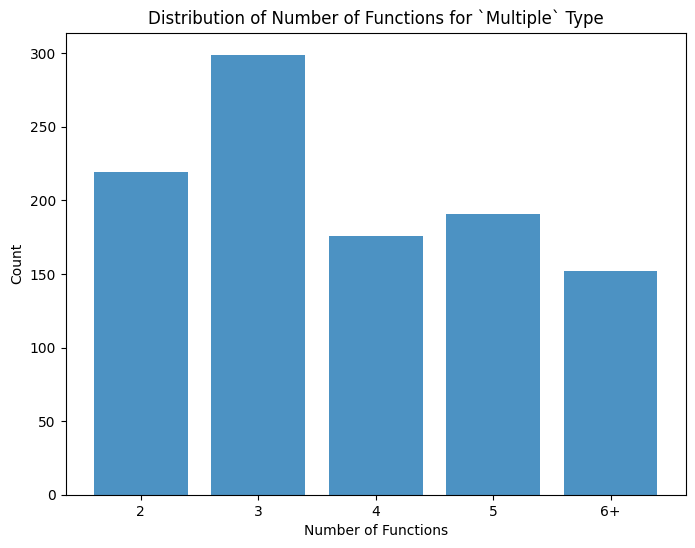

In [22]:
# get number of functions for each item
def get_number_of_functions(item):
    return len(item['function'])

# Define bins for number of functions
bins = [2, 3, 4, 5, 6, float('inf')]
bin_labels = ['2', '3', '4', '5', '6+']


# Look at the distribution of the number of functions in the bins
number_of_functions = [get_number_of_functions(item) for item in real_data['multiple']]
# Create histogram data for each bin
hist_data_multiple_nfunc_analysis = []
for i in range(len(bins)-1):
    bin_min, bin_max = bins[i], bins[i+1]
    count = sum(1 for n in number_of_functions if bin_min <= n < bin_max)
    hist_data_multiple_nfunc_analysis.append(count)

fig = plt.figure(figsize=(8, 6))
plt.bar(bin_labels, hist_data_multiple_nfunc_analysis, alpha=0.8)
plt.title(f'Distribution of Number of Functions for `Multiple` Type')
plt.xlabel('Number of Functions')
plt.ylabel('Count')
plt.show()


In [23]:
# sample the data to the make sure each bin has the same number of items, we use the number of items in the average bin as the number of items to sample to
mean_bin_count = int(np.mean(hist_data_multiple_nfunc_analysis))
print(f'Sampling to {mean_bin_count} items per bin')
sampled_real_data_multiple = {} # bin: list of items
for i in range(len(bins)-1):
    bin_min, bin_max = bins[i], bins[i+1]
    sampled_real_data_multiple[bin_labels[i]] = []
    for item in real_data['multiple']:
        if bin_min <= get_number_of_functions(item) < bin_max:
            sampled_real_data_multiple[bin_labels[i]].append(item)

for bin_label in sampled_real_data_multiple.keys():
    sampled_real_data_multiple[bin_label] = np.random.choice(sampled_real_data_multiple[bin_label], mean_bin_count, replace=True)
    print(f'{bin_label}: {len(sampled_real_data_multiple[bin_label])} items')


Sampling to 207 items per bin
2: 207 items
3: 207 items
4: 207 items
5: 207 items
6+: 207 items


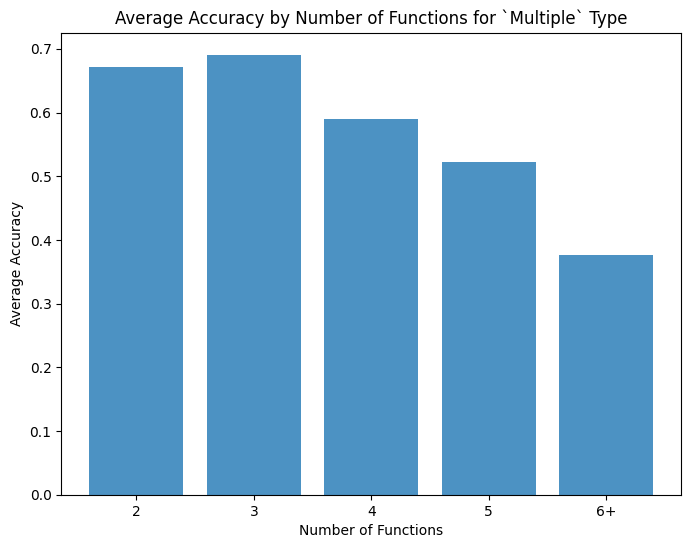

In [24]:
# Calculate average accuracy for each bin
# Calculate average accuracy for each bin
accuracies = {}
for bin_label, items in sampled_real_data_multiple.items():
    total_accuracy = 0
    for item in items:
        total_accuracy += int(item['valid'])
    accuracies[bin_label] = total_accuracy / len(items)

# Plot the results
plt.figure(figsize=(8,6))
plt.bar(accuracies.keys(), accuracies.values(), alpha=0.8)
plt.title(f'Average Accuracy by Number of Functions for `Multiple` Type')
plt.xlabel('Number of Functions') 
plt.ylabel('Average Accuracy')
plt.show()
